In [1]:
import importlib
import sys
sys.path.insert(0, '/cndd/fangming/CEMBA/snmcseq_dev')

from __init__ import *
from __init__jupyterlab import *
import datetime
from scipy import sparse
import collections
import itertools
import re
import fbpca
import pickle
import scipy.cluster.hierarchy as sch
from sklearn.metrics import euclidean_distances
import h5py

import snmcseq_utils
importlib.reload(snmcseq_utils)
import CEMBA_run_tsne
import CEMBA_clst_utils
import SCF_utils
importlib.reload(SCF_utils)

import seaborn as sns 
import matplotlib.pyplot as plt

In [2]:
figure_format = '/cndd2/fangming/projects/miniatlas/results/figures/{}.pdf'

### Gene annot 

In [3]:
f = PATH_GENEBODY_ANNOTATION
df_genes = pd.read_csv(f, sep='\t')
df_genes['gid'] = df_genes['gene_id'].apply(lambda x: x.split('.')[0])
print(df_genes.shape)
df_genes.head()


df_genes_v2 = df_genes.groupby('gene_name').first()
print(df_genes_v2.shape)
df_genes_v2.head()

(53379, 8)
(53278, 7)


,gene_id,chr,start,end,strand,gene_type,gid
gene_name,,,,,,,
0610005C13Rik,ENSMUSG00000109644.1,chr7,45567794,45575327,-,antisense_RNA,ENSMUSG00000109644
0610006L08Rik,ENSMUSG00000108652.1,chr7,74818818,74853813,-,lincRNA,ENSMUSG00000108652
0610009B22Rik,ENSMUSG00000007777.9,chr11,51685386,51688874,-,protein_coding,ENSMUSG00000007777
0610009E02Rik,ENSMUSG00000086714.1,chr2,26445696,26459390,+,processed_transcript,ENSMUSG00000086714
0610009L18Rik,ENSMUSG00000043644.4,chr11,120348678,120351190,+,bidirectional_promoter_lncRNA,ENSMUSG00000043644


### Ephys or Morph

In [7]:
f = '/cndd/fangming/CEMBA/data/MOp_all/data_freeze_it/patchseq_metadata.tsv'
meta = pd.read_csv(f, sep='\t')
print(meta.shape)
meta.head()

(253, 115)


,Cell,Number,Date,Sample,Mouse,Mouse date of birth,Mouse age,Targeted layer,Cre,Number of genes detected,...,dendrite z-bias,mean initial segment radius,normalized depth,soma radius,stems,stems exiting down,stems exiting to the sides,stems exiting up,normalized layer,cell class
0,20171204_sample_4,2,2017-12-04,sample 4,mouse_GTOKH,2017-10-29,36,5,PV-,10882,...,480.56,NaN,0.481986,8.746500,7.0,0.285714,0.571429,0.142857,5,exc
1,20171204_sample_5,3,2017-12-04,sample 5,mouse_GTOKH,2017-10-29,36,5,PV-,14950,...,464.87,NaN,0.450713,10.594785,8.0,0.250000,0.500000,0.250000,5,exc
2,20171207_sample_6,7,2017-12-07,sample 6,mouse_UGZSW,2017-09-18,80,5,SST-,13097,...,676.64,NaN,0.525323,10.786609,10.0,0.100000,0.700000,0.200000,5,exc
3,20171207_sample_7,8,2017-12-07,sample 7,mouse_UGZSW,2017-09-18,80,5,SST-,15527,...,398.10,NaN,0.436059,8.090884,6.0,0.166667,0.666667,0.166667,5,exc
4,20171219_sample_1,9,2017-12-19,sample 1,mouse_KKXUD,2017-10-19,61,5,PV-,9006,...,-102.84,NaN,0.482852,11.141210,10.0,0.100000,0.600000,0.300000,5,exc


In [8]:
f = '/cndd/fangming/CEMBA/data/MOp_all/results/intg_summary_mop_11mods_it_noatac_200227.tsv'
df_info = pd.read_csv(f, sep='\t', index_col=0)
meta = pd.merge(meta, df_info, left_on='Cell', right_index=True)
print(meta.shape)
meta.head()

(253, 122)


,Cell,Number,Date,Sample,Mouse,Mouse date of birth,Mouse age,Targeted layer,Cre,Number of genes detected,...,stems exiting up,normalized layer,cell class,cluster_joint_r0.1,cluster_joint_r0.2,cluster_joint_r0.4,cluster_joint_r0.8,tsne_x,tsne_y,modality
0,20171204_sample_4,2,2017-12-04,sample 4,mouse_GTOKH,2017-10-29,36,5,PV-,10882,...,0.142857,5,exc,3,5,3,1,-3.559987,-10.321269,patchseq
1,20171204_sample_5,3,2017-12-04,sample 5,mouse_GTOKH,2017-10-29,36,5,PV-,14950,...,0.250000,5,exc,3,5,3,1,-0.496785,-8.603842,patchseq
2,20171207_sample_6,7,2017-12-07,sample 6,mouse_UGZSW,2017-09-18,80,5,SST-,13097,...,0.200000,5,exc,3,5,3,1,0.367985,-10.762361,patchseq
3,20171207_sample_7,8,2017-12-07,sample 7,mouse_UGZSW,2017-09-18,80,5,SST-,15527,...,0.166667,5,exc,3,5,3,1,-1.488338,-9.015206,patchseq
4,20171219_sample_1,9,2017-12-19,sample 1,mouse_KKXUD,2017-10-19,61,5,PV-,9006,...,0.300000,5,exc,1,4,5,11,6.154727,-7.571096,patchseq


In [20]:
def filter_type(x):
    if x in it_types:
        return x
    else:
        return "nonIT"
    
def filter_type2(x):
    if x == 'NA':
        return "nonIT" 
    else:
        return str(int(float(x)))
    
    
meta['cluster_joint_r0.4'] = meta['cluster_joint_r0.4'].fillna('NA').astype(str).apply(filter_type2)

In [5]:
meta.columns.values
cols = meta.describe().columns.values


['L2/3 IT_2' 'L2/3 IT_3' 'L4/5 IT_1' 'L4/5 IT_2' 'L5 IT_1' 'L5 IT_2'
 'L5 IT_3' 'L5 IT_4' 'L6 IT_1' 'L6 IT_2']


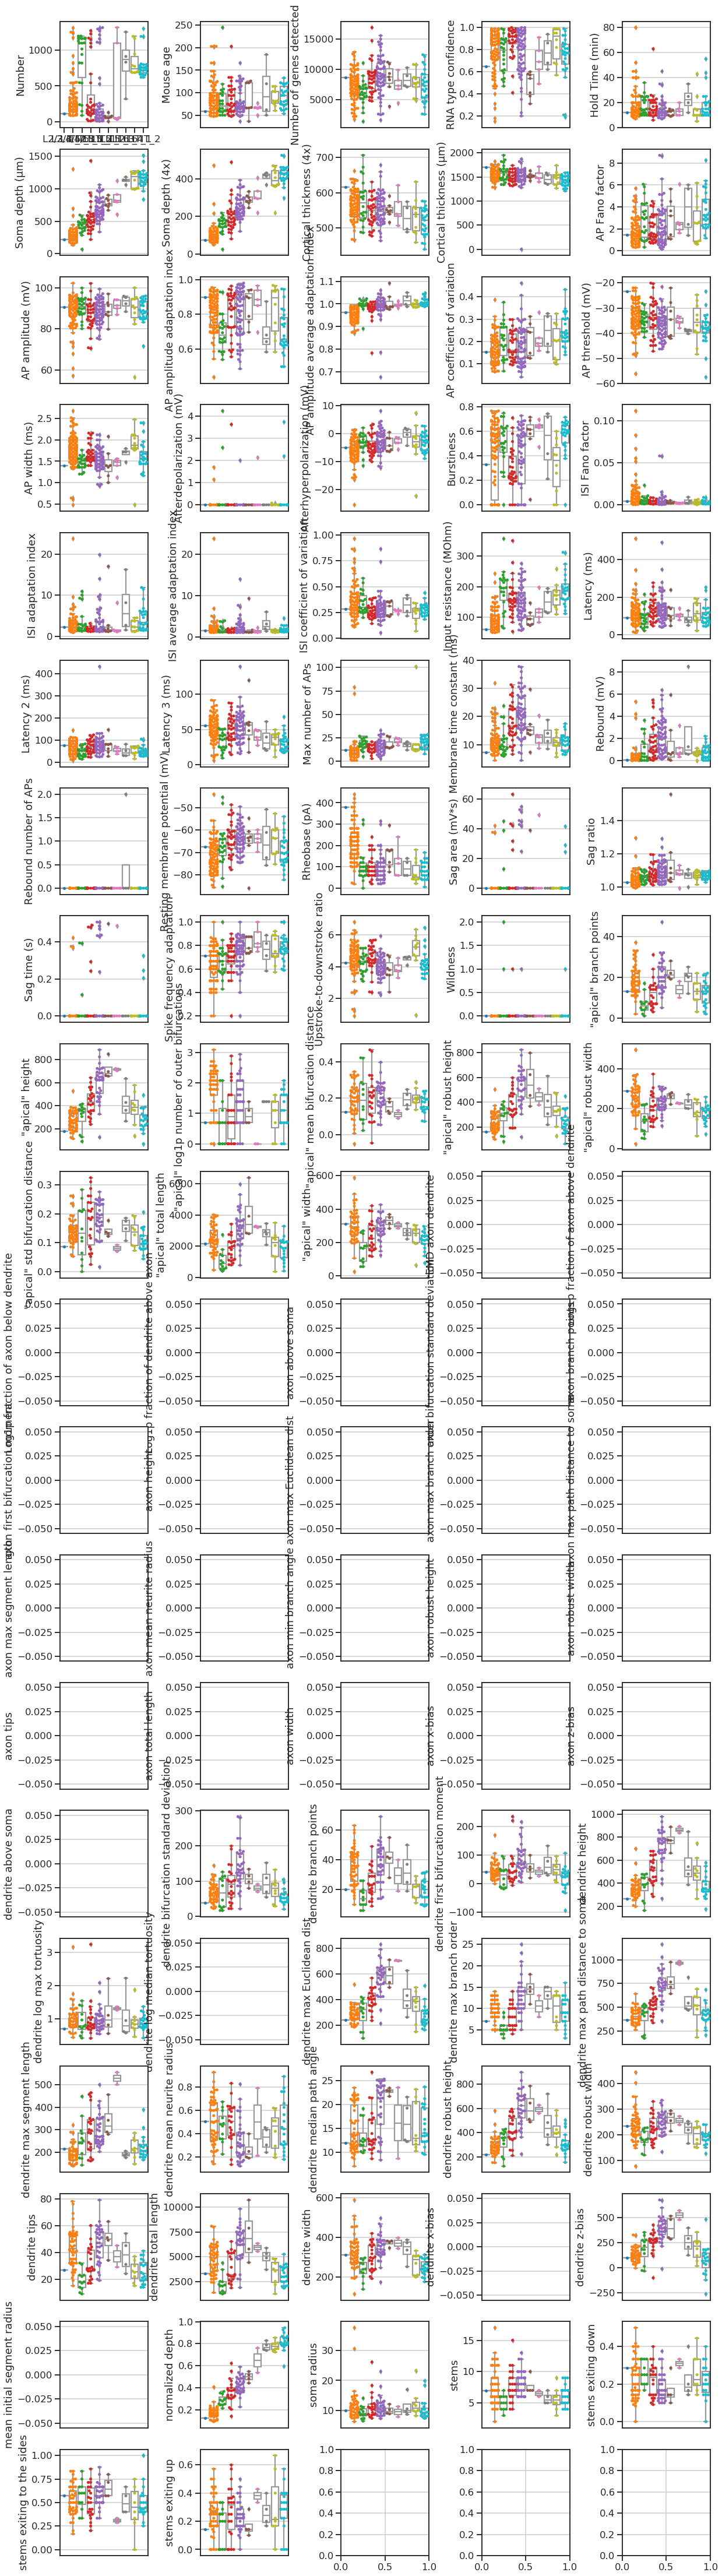

In [6]:
n = len(cols)
nx = 5
ny = int((n+nx-1)/nx)
order = np.sort(meta['RNA type'].unique()) 
print(order)

fig, axs = plt.subplots(ny, nx, figsize=(nx*4, ny*4))
axs = axs.flatten()
for i, (col, ax) in enumerate(zip(cols, axs)):
    sns.boxplot(ax=ax, y=col, x='RNA type', data=meta, color='white', order=order)
    sns.swarmplot(ax=ax, y=col, x='RNA type', data=meta, order=order)
    ax.set_xlabel('')
    if i != 0:
        ax.set_xticks([])
fig.subplots_adjust(wspace=0.6)
snmcseq_utils.savefig(fig, figure_format.format('patchseq_features_it'))
plt.show()

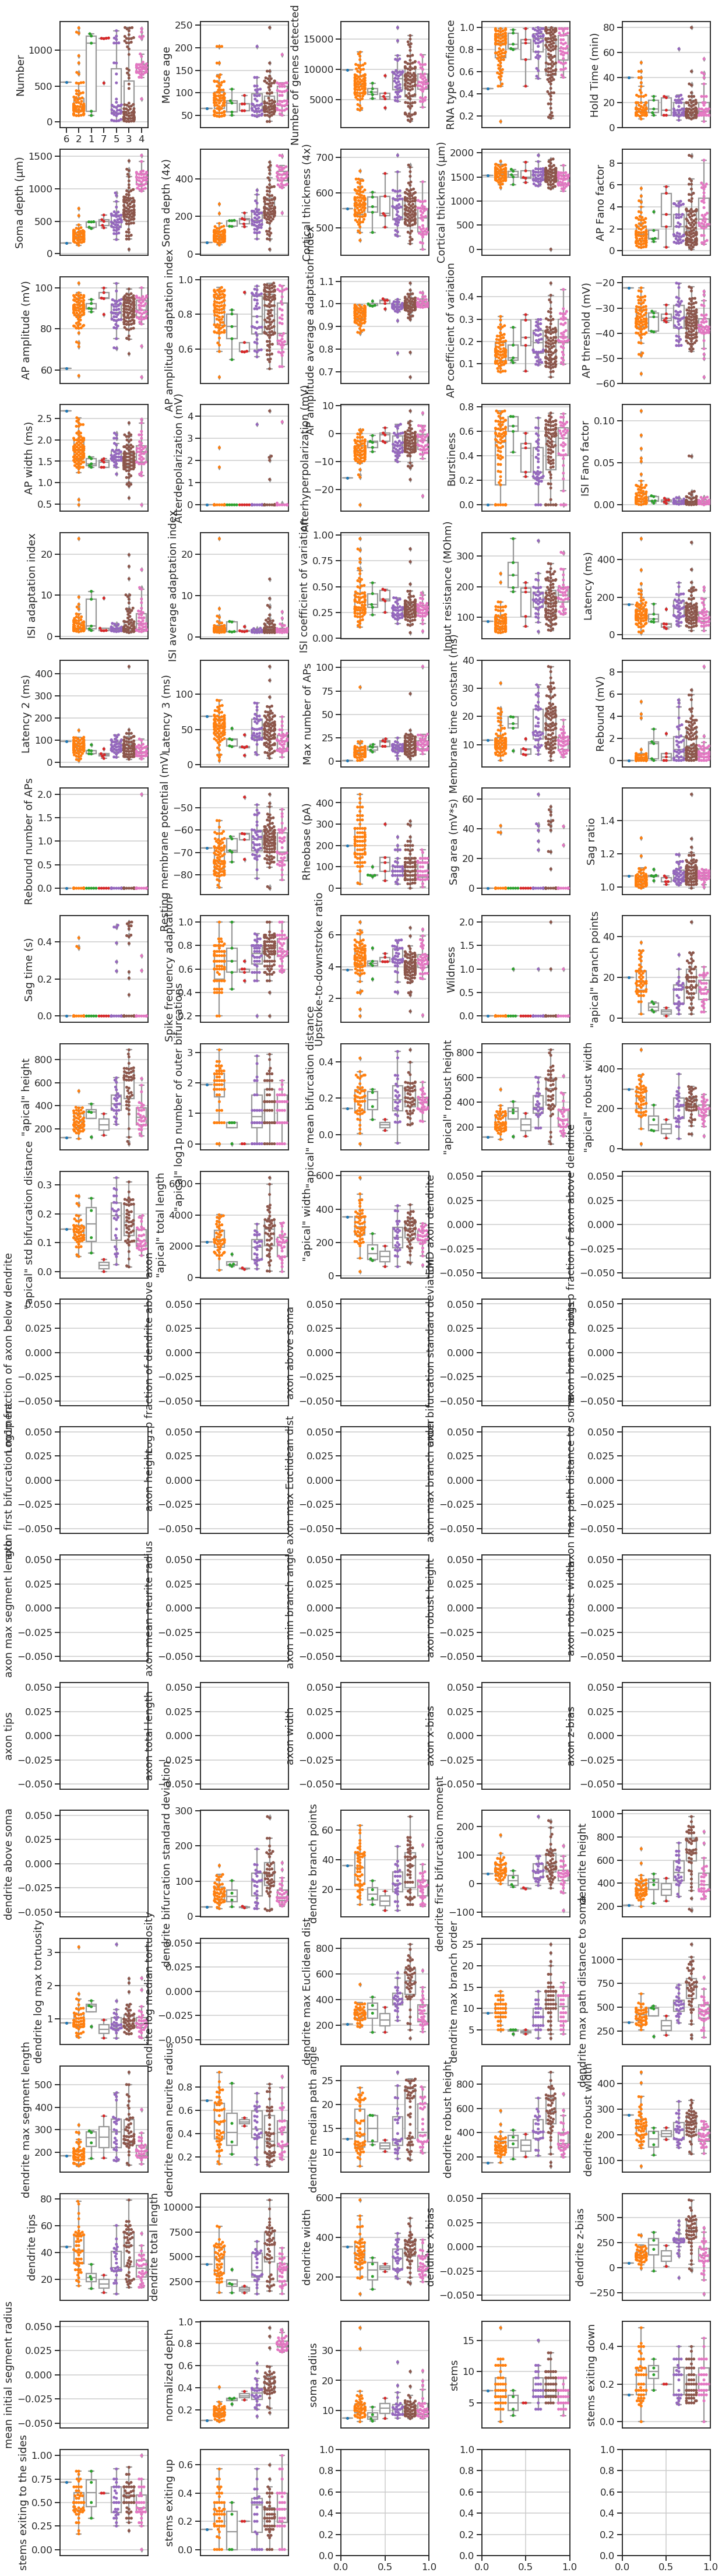

In [10]:
n = len(cols)
nx = 5
ny = int((n+nx-1)/nx)

joint_cluster = 'cluster_joint_r0.4'
order = [6, 2, 1, 7, 5, 3, 4] 
print(order)

fig, axs = plt.subplots(ny, nx, figsize=(nx*4, ny*4))
axs = axs.flatten()
for i, (col, ax) in enumerate(zip(cols, axs)):
    sns.boxplot(ax=ax, y=col, x=joint_cluster, data=meta, color='white', order=order)
    sns.swarmplot(ax=ax, y=col, x=joint_cluster, data=meta, order=order)
    ax.set_xlabel('')
    if i != 0:
        ax.set_xticks([])
fig.subplots_adjust(wspace=0.6)
snmcseq_utils.savefig(fig, 'patchseq_features_it_joint_clusters')
plt.show()

In [14]:
cm_tab20 = plt.get_cmap('tab20').colors
cm_tab20b = plt.get_cmap('tab20b').colors
cm_tab20c = plt.get_cmap('tab20c').colors

['6', '2', '1', '7', '5', '3', '4']


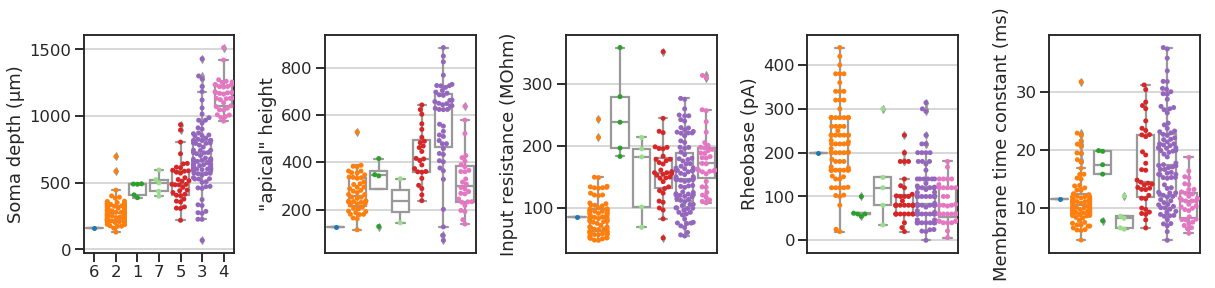

In [33]:
kw_colors=collections.OrderedDict({
                                    "nonIT": cm_tab20c[19], # lightgray
                                    '6': 'C0', # L23
                                    '2': 'C1', # L23
    
                                    '1': 'C2', # L45
                                    '7': cm_tab20[5], # L45 (1)
                                    '5': 'C3', # L45
    
                                    '3': 'C4', # L5
                                    '4': 'C6', # L6
    
                                    '8': 'C5', # L6 Car3
                                  })




selected_cols = ['Soma depth (µm)', 
                 '"apical" height',
                 'Input resistance (MOhm)',
                 'Rheobase (pA)',
                 'Membrane time constant (ms)',
                ]

n = len(selected_cols)
nx = 5
ny = int((n+nx-1)/nx)

joint_cluster = 'cluster_joint_r0.4'
order = ['6', '2', '1', '7', '5', '3', '4'] 
print(order)

fig, axs = plt.subplots(ny, nx, figsize=(nx*4, ny*4))
axs = axs.flatten()
for i, (col, ax) in enumerate(zip(selected_cols, axs)):
    sns.boxplot(ax=ax, y=col, x=joint_cluster, data=meta, color='white', order=order)
    sns.swarmplot(ax=ax, y=col, x=joint_cluster, data=meta, order=order, 
                  palette=kw_colors, rasterized=True)
    ax.set_xlabel('')
    if i != 0:
        ax.set_xticks([])
    
fig.subplots_adjust(wspace=0.6)
snmcseq_utils.savefig(fig, figure_format.format('patchseq_features_it_joint_clusters_selected'))
plt.show()

['L2/3 IT_2' 'L2/3 IT_3' 'L4/5 IT_1' 'L4/5 IT_2' 'L5 IT_1' 'L5 IT_2'
 'L5 IT_3' 'L5 IT_4' 'L6 IT_1' 'L6 IT_2']


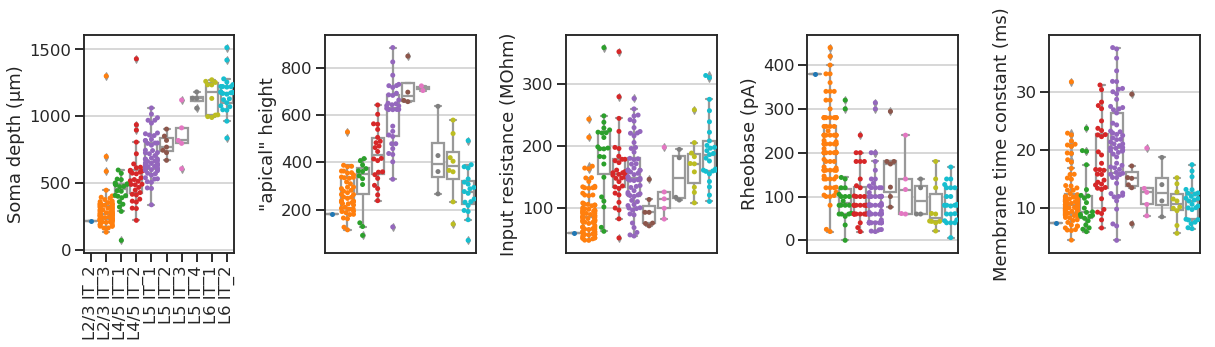

In [32]:
# kw_colors=collections.OrderedDict({
#                                     "nonIT": cm_tab20c[19], # lightgray
#                                     '6': 'C0', # L23
#                                     '2': 'C1', # L23
    
#                                     '1': 'C2', # L45
#                                     '7': cm_tab20[5], # L45 (1)
#                                     '5': 'C3', # L45
    
#                                     '3': 'C4', # L5
#                                     '4': 'C6', # L6
    
#                                     '8': 'C5', # L6 Car3
#                                   })




selected_cols = ['Soma depth (µm)', 
                 '"apical" height',
                 'Input resistance (MOhm)',
                 'Rheobase (pA)',
                 'Membrane time constant (ms)',
                ]

n = len(selected_cols)
nx = 5
ny = int((n+nx-1)/nx)

joint_cluster = 'RNA type'
order = np.sort(meta['RNA type'].unique()) 
print(order)

fig, axs = plt.subplots(ny, nx, figsize=(nx*4, ny*4))
axs = axs.flatten()
for i, (col, ax) in enumerate(zip(selected_cols, axs)):
    sns.boxplot(ax=ax, y=col, x=joint_cluster, data=meta, color='white', order=order)
    sns.swarmplot(ax=ax, y=col, x=joint_cluster, data=meta, order=order, 
                  rasterized=True)
    ax.set_xlabel('')
    if i != 0:
        ax.set_xticks([])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    
fig.subplots_adjust(wspace=0.6)
snmcseq_utils.savefig(fig, figure_format.format('patchseq_features_it_selected'))
plt.show()